# Load tfrecords, define model and train

In [1]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from keras import layers
from keras import models

#Tensorboard
%load_ext tensorboard


# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import datetime        
from scipy.io.wavfile import write


# Check if the GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")



Tensorflow Version: 2.9.1
GPU not available :(


In [18]:
# load train tfrecords

# get relative path of train tfrecords
print(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), os.pardir, 'Dataset', 'train_tfrecords')))

# current directory
print(os.getcwd())


tfrecords_paths = glob.glob('../Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths[:3])


# count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')



/Dataset/train_tfrecords
/Users/marius
Number of elements in train_dataset: 0


In [2]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)

# define some extra values
config['batch_size'] = 16
config['shuffle_buffer_size'] = 300

# print config
#print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


# funcs 

In [3]:
# autotune for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# decode tfrecords
def decode_tf_records(seralized_example):
    feature_description = {
        "voicefixer": tf.io.FixedLenFeature([], tf.string),
        "produced": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(seralized_example, feature_description)

    voicefixer, _ = tf.audio.decode_wav(example["voicefixer"], desired_channels=-1)
    produced, _ = tf.audio.decode_wav(example["produced"], desired_channels=-1)
    
    return voicefixer, produced


def slicing_audio(voicefixer, produced):
    # generate random integer between 0 and 10*44100-3*44100
    random_int = tf.random.uniform(shape=[], minval=0, maxval=7*44100, dtype=tf.int32)
    # slice audio
    voicefixer = voicefixer[random_int:random_int+3*44100]
    produced = produced[random_int:random_int+3*44100]
    return voicefixer, produced
 

#--------------------------------------------
# helper func
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


#--------------------------------------------
# get audiofile from dataset and use as input for prediction
def set_speechfile(test_dataset, log_dir):


    dataset = test_dataset.unbatch().as_numpy_iterator()
    speech_for_predicition = []
    for i, sample in enumerate(dataset):
        speech_for_predicition.append(sample[0])
        break
    # # normalize speechfile
    speech_for_predicition = speech_for_predicition[0]
    speech_for_predicition = librosa.util.normalize(speech_for_predicition)
    
    # save speech file used for prediction
    # save plot to disk
    plt.figure(figsize=(8, 4))
    x = np.arange(0, len(speech_for_predicition)/44100, 1/44100)
    plt.plot(x, speech_for_predicition)
    plt.title('Speechfile used for prediction')
    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')
    plt.savefig(log_dir + '/_audiofile_for_prediction.png')
    plt.show()
    
    # save audiofile to disk
    write(log_dir + '/_audiofile_for_prediction' + '.wav', int(44100), float2pcm(speech_for_predicition))
   
    return speech_for_predicition


#--------------------------------------------
# save audio files from logs to tf.summary.audio and event files for tensorboard
def save_audio_to_summaries(log_dir):
    
        # get audio files from logs
        fps = glob.glob(log_dir + '/*.wav')
        path_audiosummary = log_dir + '/audiosummary/'

        # for each audio file
        for idx, fp in enumerate(fps):
            
            # write audiosummary of one audio file to disk
             writer = tf.summary.create_file_writer(path_audiosummary)
             with writer.as_default():
                
                # load audio file as tensor
                file = tf.io.read_file(fp)
                audio = tf.audio.decode_wav(file, desired_channels=1)

                # write audio file to tf.summary.audio
                name = fp.split('/')[-1]
                tf.summary.audio(name , tf.expand_dims(audio[0], 0), int(44100), step=idx)
                writer.flush()


#--------------------------------------------
import tensorflow as tf
class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(y_mag, ord="fro", axis=(-2, -1))


class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag) - tf.math.log(x_mag))


class TFSTFT(tf.keras.layers.Layer):
    """STFT loss module."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """

        x = tf.transpose(x, perm=[0, 2, 1])
        y = tf.transpose(y, perm=[0, 2, 1])        

        x_mag = tf.abs(tf.signal.stft(signals=x,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))
        y_mag = tf.abs(tf.signal.stft(signals=y,
                                      frame_length=self.frame_length,
                                      frame_step=self.frame_step,
                                      fft_length=self.fft_length))

        # add small number to prevent nan value.
        # compatible with pytorch version.
        x_mag = tf.math.sqrt(x_mag ** 2 + 1e-7)
        y_mag = tf.math.sqrt(y_mag ** 2 + 1e-7)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss
    
    
class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(self,
                 fft_lengths=[1024, 2048, 512],
                 frame_lengths=[600, 1200, 240],
                 frame_steps=[120, 240, 50],):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(frame_lengths, frame_steps, fft_lengths):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l)
            mag_loss += tf.reduce_mean(mag_l)

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return mag_loss


class CustomLoss(tf.keras.losses.Loss):
    """custom loss calculated from MAE and Multiresolution STFT loss"""

    def __init__(self):
        super().__init__()
        self.mae = tf.keras.losses.MeanAbsoluteError()
        self.stft = TFMultiResolutionSTFT()


    def call(self, y_true, y_pred):
        mae = self.mae(y_true, y_pred)
        stft = self.stft(y_true, y_pred)
        return ((mae+stft) / 2)




# Check if losses work

(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(132300, 1) (132300, 1)
(1, 132300)


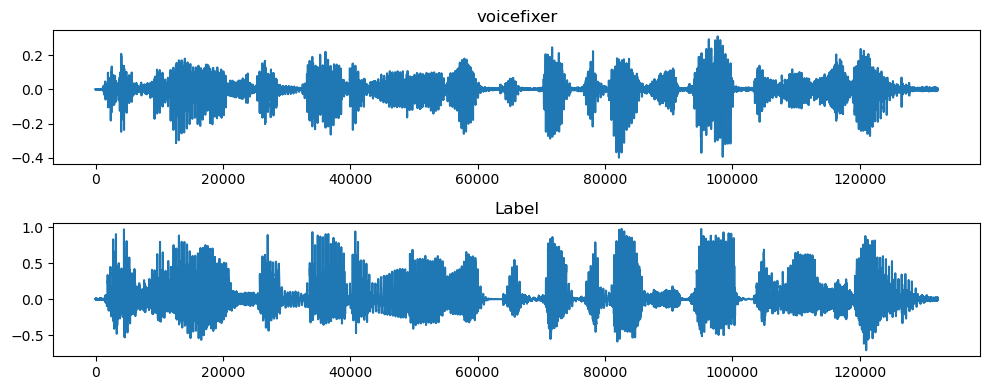

Stft loss is:1.1987042427062988
MAE loss is:0.10224420577287674
custom loss is:0.6504742503166199
-------------------
Stft loss is:1.3180347681045532
MAE loss is:0.13288937509059906
custom loss is:0.7254620790481567
-------------------
Stft loss is:1.107269287109375
MAE loss is:0.06669673323631287
custom loss is:0.5869830250740051
-------------------
Stft loss is:1.2269645929336548
MAE loss is:0.10266312956809998
custom loss is:0.6648138761520386
-------------------
Stft loss is:1.2447004318237305
MAE loss is:0.09991291165351868
custom loss is:0.6723066568374634
-------------------
Stft loss is:1.1453046798706055
MAE loss is:0.07670972496271133
custom loss is:0.6110072135925293
-------------------
Stft loss is:1.0932892560958862
MAE loss is:0.07160969078540802
custom loss is:0.5824494957923889
-------------------
Stft loss is:1.1576342582702637
MAE loss is:0.10166207700967789
custom loss is:0.6296481490135193
-------------------
Stft loss is:1.223617672920227
MAE loss is:0.095568850636

In [75]:
import numpy as np
loss1 = TFMultiResolutionSTFT()
loss2 = tf.keras.losses.MeanAbsoluteError()
loss3 = CustomLoss()


# load train tfrecords
path = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
DS = tf.data.TFRecordDataset(path[:5])
DS = DS.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
DS = DS.map(slicing_audio, num_parallel_calls=AUTOTUNE)


sf = []
label = []

for y, X in DS.take(10):
  print(y.numpy().shape, X.numpy().shape)
  sf.append(y.numpy().T)
  label.append(X.numpy().T)

print(sf[0].shape)

# # transpose 
# file = tf.transpose(sf[0])
# file2 = sf[0].T

# print(file.shape)
# print(file2.shape)


# plot waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)     
plt.title('voicefixer')
plt.plot(sf[0].T)
plt.subplot(2, 1, 2)
plt.title('Label')
plt.plot(label[0].T)
plt.tight_layout()
plt.show()



for i in range(len(sf)):
  print(f'Stft loss is:{loss1(label[i], sf[i])}')
  print(f'MAE loss is:{loss2(label[i], sf[i])}')
  print(f'custom loss is:{loss3(label[i], sf[i])}')
  print('-------------------')




# Load datasets

In [4]:
# load train tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/*.tfrecords')
train_dataset = tf.data.TFRecordDataset(tfrecords_paths[:1])
train_dataset = train_dataset.take(1)
train_dataset = train_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in train_dataset
print(f'Number of elements in train_dataset: {len([d for d in train_dataset])}')

# batching and shuffling
train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in train_dataset: 1


2023-08-10 17:25:51.803797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load test tfrecords
tfrecords_paths = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/*.tfrecords')
test_dataset = tf.data.TFRecordDataset(tfrecords_paths[:1])
test_dataset = test_dataset.take(1)

test_dataset = test_dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(slicing_audio, num_parallel_calls=AUTOTUNE)

# count elements in test_dataset
print(f'Number of elements in test_dataset: {len([d for d in test_dataset])}')

# batching and shuffling
test_dataset = test_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])


Number of elements in test_dataset: 1


In [6]:
# check if datasets are loaded correctly
for d in train_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break   

for d in test_dataset:
    print(d[0].shape)
    print(d[1].shape)
    break

(1, 132300, 1)
(1, 132300, 1)
(1, 132300, 1)
(1, 132300, 1)


# Model architecture

In [7]:
# some values for training
config['n_epochs'] = 50
config['learning_rate'] = 0.004
# Filter:Kernel = 4:1 (see hifi-gan paper)
config['filter_size'] = 64
config['kernel_size'] = 5
config['dropout_rate'] = 0.5

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

In [32]:
# some values for the model
input_shape = (3*44100, 1)
output_channels = 1


# build model with 12 layers
def build_model(input_shape):

    # define model
    model = keras.Sequential(name='PostNet_Conv1D')
    model.add(keras.Input(shape=input_shape))

    # add layer 
    model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
    # add dropout layer, batch normalization and activation layer
    #model.add(keras.layers.Dropout(config['dropout_rate']))
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('tanh'))

    # Add the remaining Conv1D layers
    for _ in range(11):
        model.add(keras.layers.Conv1D(filters=config['filter_size'], kernel_size=config['kernel_size'], padding='same'))
        # add dropout layer, batch normalization and activation layer
        #model.add(keras.layers.Dropout(config['dropout_rate']))
        #model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('tanh'))

    # Add the final Conv1D layer without activation layer
    model.add(keras.layers.Conv1D(filters=output_channels, kernel_size=1, padding='same'))
    #model.add(keras.layers.Dropout(config['dropout_rate']))
    #model.add(keras.layers.BatchNormalization())

    return model

# Callbacks and compile

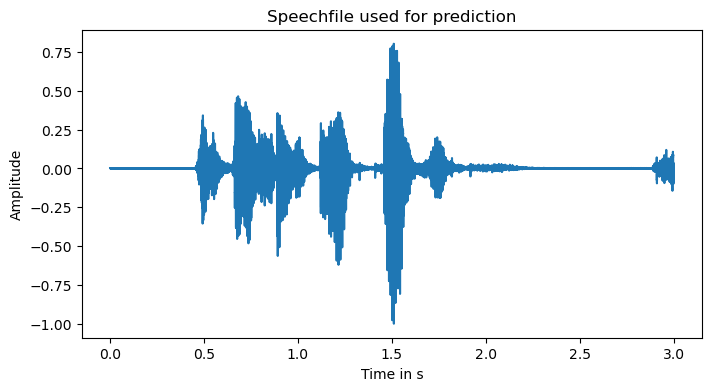

Model: "PostNet_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 132300, 64)        384       
                                                                 
 activation_12 (Activation)  (None, 132300, 64)        0         
                                                                 
 conv1d_27 (Conv1D)          (None, 132300, 64)        20544     
                                                                 
 activation_13 (Activation)  (None, 132300, 64)        0         
                                                                 
 conv1d_28 (Conv1D)          (None, 132300, 64)        20544     
                                                                 
 activation_14 (Activation)  (None, 132300, 64)        0         
                                                                 
 conv1d_29 (Conv1D)          (None, 132300, 64)     

In [33]:
# initialize log_dir
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# make directory if not exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


#--------------------------------------------
# define callbacks

save_callback = keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint',
    save_best_only=False,
    monitor='val_loss',
    verbose=0)

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir= log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=True,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=1)

# early_stopping_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     verbose=1)


# get speechfile for prediction
speech_for_predicition = set_speechfile(test_dataset, log_dir)

#--------------------------------------------
# # define custom callback
# class CustomCallback(keras.callbacks.Callback):
     
#     # define functions to happen during training after each epoch
#     def on_epoch_end(self, epoch, logs=None):
        
#         # # print(logs) to check metrics
#         # print('---------------------')
#         # print(f'Epoch {epoch+1} Metrics:')
#         # print(logs)
#         # print('---------------------')
#         # print('')
        

#         # save predicted audio file after each epoch to disk
#         # get audio file from model prediciton
#         audio = self.model.predict(speech_for_predicition)

#         # change shape to (len(audio), 1)
#         audio = tf.squeeze(audio, axis=-1)
#         audio = tf.squeeze(audio, axis=-1).numpy()
#         #print(audio.shape)

#         # normalize audio with numpy
#         #audio = librosa.util.normalize(audio).astype(np.float32)
#         audio = audio.astype(np.float32)

#         # save plot to disk
#         plt.figure(figsize=(8, 4))
#         x = np.arange(0, len(audio)/44100, 1/44100)
#         plt.plot(x, audio)
#         plt.title('Audiofile')
#         plt.xlabel('Time in s')
#         plt.ylabel('Amplitude')
#         plt.savefig(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.png')
#         plt.close()

#         # write audio file to disk (16-bit PCM WAV)
#         write(log_dir + '/_audiofile_epoch' + str(epoch+1) + '.wav', 44100, float2pcm(audio))


#--------------------------------------------
# get model
model = build_model(input_shape = input_shape)

# compile model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss = CustomLoss(),
              metrics = tf.keras.losses.MeanAbsoluteError())

model.summary()


In [82]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

# Model fit and save

In [34]:
# fit model
history = model.fit(train_dataset,
                    epochs=config['n_epochs'],
                    validation_data=test_dataset,
                    callbacks=[save_callback, tensorboard_callback])

# save model
model.save('./model.keras')

# save history
with open('./history.json', 'w+') as fp:
    json.dump(history.history, fp, sort_keys=True, indent=4)


# call def to save audio to summaries
save_audio_to_summaries(log_dir)


Epoch 1/50


      1/Unknown - 4s 4s/step - loss: 1.2006 - mean_absolute_error: 0.0902

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 7s 7s/step - loss: 1.2006 - mean_absolute_error: 0.0902 - val_loss: 1.2312 - val_mean_absolute_error: 0.9325
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.2230 - mean_absolute_error: 0.9779

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.2230 - mean_absolute_error: 0.9779 - val_loss: 0.8601 - val_mean_absolute_error: 0.4847
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.9542 - mean_absolute_error: 0.4774

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.9542 - mean_absolute_error: 0.4774 - val_loss: 1.0087 - val_mean_absolute_error: 0.7830
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 1.0761 - mean_absolute_error: 0.7857

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.0761 - mean_absolute_error: 0.7857 - val_loss: 1.4107 - val_mean_absolute_error: 1.7340
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 1.4567 - mean_absolute_error: 1.7001

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.4567 - mean_absolute_error: 1.7001 - val_loss: 0.8112 - val_mean_absolute_error: 0.3649
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.8376 - mean_absolute_error: 0.3635

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.8376 - mean_absolute_error: 0.3635 - val_loss: 0.9736 - val_mean_absolute_error: 0.5224
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 0.9673 - mean_absolute_error: 0.5797

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.9673 - mean_absolute_error: 0.5797 - val_loss: 2.1104 - val_mean_absolute_error: 2.4878
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 2.1698 - mean_absolute_error: 2.4616

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 2.1698 - mean_absolute_error: 2.4616 - val_loss: 1.3688 - val_mean_absolute_error: 1.2621
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 1.3396 - mean_absolute_error: 1.2326

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.3396 - mean_absolute_error: 1.2326 - val_loss: 1.4824 - val_mean_absolute_error: 1.6109
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 1.4580 - mean_absolute_error: 1.5786

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.4580 - mean_absolute_error: 1.5786 - val_loss: 0.6166 - val_mean_absolute_error: 0.1515
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 0.7158 - mean_absolute_error: 0.2436

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7158 - mean_absolute_error: 0.2436 - val_loss: 1.4353 - val_mean_absolute_error: 1.3591
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 1.4638 - mean_absolute_error: 1.3574

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.4638 - mean_absolute_error: 1.3574 - val_loss: 1.1050 - val_mean_absolute_error: 0.8735
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 1.1191 - mean_absolute_error: 0.8743

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 1.1191 - mean_absolute_error: 0.8743 - val_loss: 0.7934 - val_mean_absolute_error: 0.3693
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 0.7604 - mean_absolute_error: 0.3688

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7604 - mean_absolute_error: 0.3688 - val_loss: 0.6558 - val_mean_absolute_error: 0.2851
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 0.7388 - mean_absolute_error: 0.3003

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7388 - mean_absolute_error: 0.3003 - val_loss: 0.6238 - val_mean_absolute_error: 0.1636
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 0.7414 - mean_absolute_error: 0.1942

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7414 - mean_absolute_error: 0.1942 - val_loss: 0.7100 - val_mean_absolute_error: 0.2442
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: 0.7236 - mean_absolute_error: 0.2468

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7236 - mean_absolute_error: 0.2468 - val_loss: 0.5746 - val_mean_absolute_error: 0.1035
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: 0.6131 - mean_absolute_error: 0.1152

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6131 - mean_absolute_error: 0.1152 - val_loss: 0.6498 - val_mean_absolute_error: 0.2793
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: 0.7075 - mean_absolute_error: 0.2853

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7075 - mean_absolute_error: 0.2853 - val_loss: 0.7923 - val_mean_absolute_error: 0.2139
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: 0.7857 - mean_absolute_error: 0.2148

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7857 - mean_absolute_error: 0.2148 - val_loss: 0.6516 - val_mean_absolute_error: 0.1686
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: 0.6668 - mean_absolute_error: 0.1871

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6668 - mean_absolute_error: 0.1871 - val_loss: 0.5091 - val_mean_absolute_error: 0.0605
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: 0.5738 - mean_absolute_error: 0.0990

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5738 - mean_absolute_error: 0.0990 - val_loss: 0.8201 - val_mean_absolute_error: 0.5487
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: 0.8202 - mean_absolute_error: 0.5415

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.8202 - mean_absolute_error: 0.5415 - val_loss: 0.7032 - val_mean_absolute_error: 0.4033
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: 0.7973 - mean_absolute_error: 0.3983

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7973 - mean_absolute_error: 0.3983 - val_loss: 0.6242 - val_mean_absolute_error: 0.2194
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: 0.6177 - mean_absolute_error: 0.2306

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6177 - mean_absolute_error: 0.2306 - val_loss: 0.5634 - val_mean_absolute_error: 0.0591
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: 0.5900 - mean_absolute_error: 0.0882

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5900 - mean_absolute_error: 0.0882 - val_loss: 0.7287 - val_mean_absolute_error: 0.2380
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: 0.7166 - mean_absolute_error: 0.2388

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7166 - mean_absolute_error: 0.2388 - val_loss: 0.5821 - val_mean_absolute_error: 0.1202
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: 0.5979 - mean_absolute_error: 0.1266

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5979 - mean_absolute_error: 0.1266 - val_loss: 0.6329 - val_mean_absolute_error: 0.2573
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: 0.6823 - mean_absolute_error: 0.2667

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6823 - mean_absolute_error: 0.2667 - val_loss: 0.6228 - val_mean_absolute_error: 0.2432
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: 0.7082 - mean_absolute_error: 0.2660

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.7082 - mean_absolute_error: 0.2660 - val_loss: 0.5903 - val_mean_absolute_error: 0.0543
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 0.5727 - mean_absolute_error: 0.0917

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5727 - mean_absolute_error: 0.0917 - val_loss: 0.7745 - val_mean_absolute_error: 0.2230
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 0.6534 - mean_absolute_error: 0.2243

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6534 - mean_absolute_error: 0.2243 - val_loss: 0.7691 - val_mean_absolute_error: 0.2191
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 0.6849 - mean_absolute_error: 0.2196

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6849 - mean_absolute_error: 0.2196 - val_loss: 0.5818 - val_mean_absolute_error: 0.0780
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 0.5771 - mean_absolute_error: 0.1049

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5771 - mean_absolute_error: 0.1049 - val_loss: 0.5733 - val_mean_absolute_error: 0.1779
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: 0.6285 - mean_absolute_error: 0.2002

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6285 - mean_absolute_error: 0.2002 - val_loss: 0.5885 - val_mean_absolute_error: 0.1999
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: 0.6524 - mean_absolute_error: 0.2220

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6524 - mean_absolute_error: 0.2220 - val_loss: 0.5754 - val_mean_absolute_error: 0.1000
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: 0.5632 - mean_absolute_error: 0.1290

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5632 - mean_absolute_error: 0.1290 - val_loss: 0.6320 - val_mean_absolute_error: 0.1992
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: 0.6154 - mean_absolute_error: 0.1966

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6154 - mean_absolute_error: 0.1966 - val_loss: 0.6148 - val_mean_absolute_error: 0.2082
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: 0.6239 - mean_absolute_error: 0.2082

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6239 - mean_absolute_error: 0.2082 - val_loss: 0.5220 - val_mean_absolute_error: 0.0705
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: 0.5688 - mean_absolute_error: 0.1062

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5688 - mean_absolute_error: 0.1062 - val_loss: 0.5933 - val_mean_absolute_error: 0.1843
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: 0.6420 - mean_absolute_error: 0.1902

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6420 - mean_absolute_error: 0.1902 - val_loss: 0.6053 - val_mean_absolute_error: 0.1821
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 0.6136 - mean_absolute_error: 0.2014

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6136 - mean_absolute_error: 0.2014 - val_loss: 0.5697 - val_mean_absolute_error: 0.1106
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 0.5707 - mean_absolute_error: 0.1406

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5707 - mean_absolute_error: 0.1406 - val_loss: 0.5443 - val_mean_absolute_error: 0.0780
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 0.5722 - mean_absolute_error: 0.1164

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5722 - mean_absolute_error: 0.1164 - val_loss: 0.5595 - val_mean_absolute_error: 0.1226
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 0.6079 - mean_absolute_error: 0.1383

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6079 - mean_absolute_error: 0.1383 - val_loss: 0.5805 - val_mean_absolute_error: 0.1352
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 0.5871 - mean_absolute_error: 0.1377

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5871 - mean_absolute_error: 0.1377 - val_loss: 0.5735 - val_mean_absolute_error: 0.0852
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: 0.5660 - mean_absolute_error: 0.1180

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5660 - mean_absolute_error: 0.1180 - val_loss: 0.5997 - val_mean_absolute_error: 0.1084
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: 0.5746 - mean_absolute_error: 0.1265

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.5746 - mean_absolute_error: 0.1265 - val_loss: 0.6019 - val_mean_absolute_error: 0.1245
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: 0.6014 - mean_absolute_error: 0.1500

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6014 - mean_absolute_error: 0.1500 - val_loss: 0.5733 - val_mean_absolute_error: 0.1097
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: 0.6008 - mean_absolute_error: 0.1235

INFO:tensorflow:Assets written to: ./model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model_checkpoint/assets


1/1 [==============================] - 4s 4s/step - loss: 0.6008 - mean_absolute_error: 0.1235 - val_loss: 0.5781 - val_mean_absolute_error: 0.0869


# check history and simple plot

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


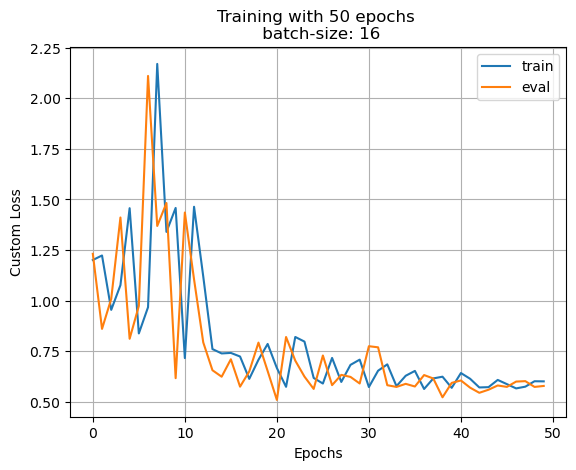

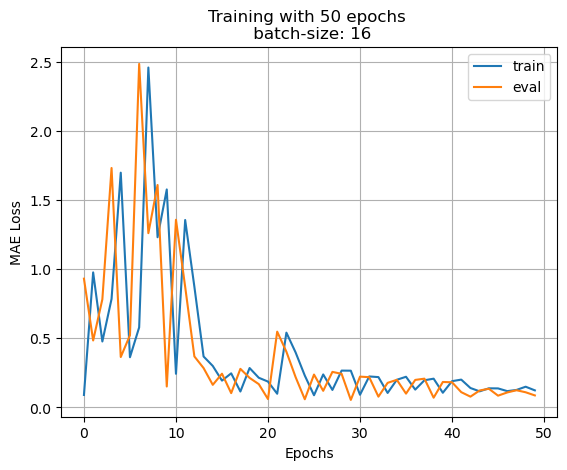

In [35]:
# open history
with open('./history.json', 'r') as fp:
  history = json.load(fp)

# check out history keys
print(history.keys())

# simple plot losses
train_loss = history['loss']
eval_loss = history['val_loss']
mae = history['mean_absolute_error']
val_mae = history['val_mean_absolute_error']



fig2 = plt.figure()
plt.plot(range(config['n_epochs']), train_loss, label='train')
plt.plot(range(config['n_epochs']), eval_loss, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Custom Loss')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  


fig3 = plt.figure()
plt.plot(range(config['n_epochs']), mae, label='train')
plt.plot(range(config['n_epochs']), val_mae, label='eval')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.title('Training with ' 
                           + str(config['n_epochs'])
                           + ' epochs \n batch-size: '
                           + str(config['batch_size']))
                     
plt.show()  

# Tensorboard

In [ ]:
%tensorboard --logdir logs

# load model from disk and predict

In [36]:
# # load model
reconstructed_model = keras.models.load_model('./model.keras', compile=False)
#reconstructed_model.summary()

# get audio file from model prediciton
audio = reconstructed_model.predict(speech_for_predicition)



# change shape to (len(audio), 1)
audio = tf.squeeze(audio, axis=-1)
audio = tf.squeeze(audio, axis=-1)



print(audio.dtype)
print(audio.shape)



4135/4135 [==============================] - 6s 1ms/step
<dtype: 'float32'>
(132300,)


In [37]:
print(audio)

# normalize audio with numpy
# audio = librosa.util.normalize(audio)

# normalize audio with tensorflow
audio = tf.math.divide(audio, tf.math.reduce_max(audio))
print(audio)


tf.Tensor(
[-0.13441592 -0.13441592 -0.13441594 ... -0.13441639 -0.13441597
 -0.1344159 ], shape=(132300,), dtype=float32)
tf.Tensor([1.0003856 1.0003856 1.0003858 ... 1.0003891 1.0003859 1.0003854], shape=(132300,), dtype=float32)


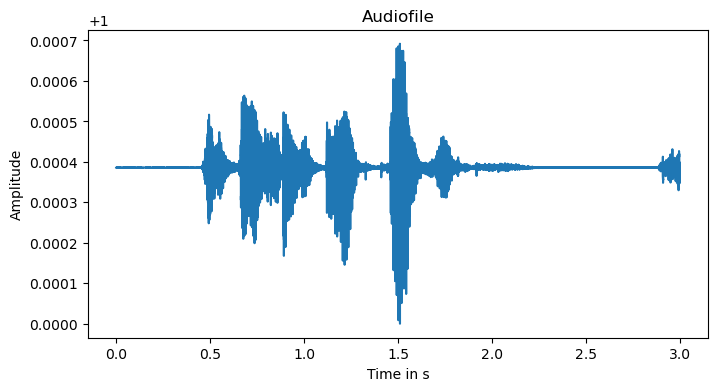

In [38]:

# save plot to disk
plt.figure(figsize=(8, 4))
x = np.arange(0, len(audio)/44100, 1/44100)
plt.plot(x, audio)
plt.title('Audiofile')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.savefig(log_dir + '/_audiofile_Reconstructed_model..png')
plt.show()

# write audio file to disk (16-bit PCM WAV)
write(log_dir + '/_audiofile_Reconstructed_model.wav', 44100, audio.numpy())

# look at data

In [12]:
# # look at some example data from train dataset
# wavs = train_dataset.unbatch().as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')